# Caecilia data re-analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy
import pickle
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import skrf as rf
import uncertainties
from scipy.constants import c, pi
from uncertainties import ufloat
from uncertainties import unumpy as unp

In [3]:
from suprtools.fp_theory.geometry import SymmetricCavityGeometry
# from sslab_txz.fp_theory.coupling import CouplingConfig
# from sslab_txz.fp_theory.modes import ScalarModeBasis
from suprtools.plotting import sslab_style
from suprtools.rf import WideScanData, Ringdown, fit_mode, test_a_fit, FabryPerotModeParams, ModeMaskingPolicy

In [4]:
mirror_test_dir = Path('../data/data')
caecilia_data_dir = mirror_test_dir / 'Caecilia'
cassia_data_dir = mirror_test_dir / 'Cassia'
domitia_data_dir = mirror_test_dir / 'Domitia'
egnatia_data_dir = mirror_test_dir / 'Egnatia'

In [5]:
condense_data_dir = caecilia_data_dir / '20221208-cooldown-segment-scan' / 'data'

In [6]:
condense_datas = [
    WideScanData.from_window(p, network_name=p.stem) for p in sorted(condense_data_dir.glob('sweep*.h5'))
]

In [7]:
cooldown_sweep_fit_params = [
    [
        (90.83705, 4, 4),
        (94.26480, 5, 4),
        (97.69214, 5, 3),
        (101.1194, 4, 3),
        (104.54662, 5, 4),
        (107.97384, 2.5, 4),
    ],
    [
        (90.83750, 4, 4),
        (94.26525, 5, 4),
        (97.69259, 5, 3),
        (101.11985, 4, 3),
        (104.54704, 5, 4),
        (107.97422, 2.5, 4),
    ],
    [
        (90.84682, 2.5, 4),
        (94.27499, 2.5, 4),
        (97.70308, 4, 4),
        (101.13107, 4, 4),
        (104.55901, 4, 4),
        (107.98683, 4, 4),
    ],
    [
        (90.84697, 2.5, 4),
        (94.27518, 4, 4),
        (97.70327, 4, 4),
        (101.13125, 4, 4),
        (104.55918, 4, 4),
        (107.98701, 4, 4),
    ],
]

In [8]:
# select only scan #30 (when we are cooled down to 0.8 K)
selection_slice = slice(30, 31)
# selection_slice = slice(None)  # to fit all scans, which takes quite a while

In [9]:
all_modes_info = []
for i, mode_series in enumerate(cooldown_sweep_fit_params[:2]):
    series_info = []
    for j, (freq_ghz, span_mhz, n_poles_cmplx) in enumerate(mode_series):
        mode_info = []
        
        print(i, j)
        for condense_data in condense_datas[selection_slice]:
            try:
                vf = fit_mode(condense_data.s21, freq_ghz, span_mhz / 1e3, n_poles_cmplx=n_poles_cmplx)
            except RuntimeError:
                mode_info.append({
                    key: (ufloat(np.nan, np.nan), ufloat(np.nan, np.nan))
                    for key in ['pole', 'residue']
                })
                continue

            localized_mode_mask = (unp.std_devs(vf.refined_resonances) < 400e+3)
            nominal_freqs = unp.nominal_values(vf.refined_resonances)
            masked_distances = np.where(
                localized_mode_mask,
                np.abs(nominal_freqs - freq_ghz * 1e+9),
                np.inf,
            )
            mode_ind = np.argmin(masked_distances)

            mode_info.append({
                key: (
                    vf.refined_fit_params[f'{key}s']['real'][mode_ind],
                    vf.refined_fit_params[f'{key}s']['imag'][mode_ind],
                )
                for key in ['pole', 'residue']
            })
        series_info.append(mode_info)
    all_modes_info.append(series_info)

0 0


/Users/txz/Dropbox (Personal)/stanford/sslab/suprtools/build/__editable__.suprtools-2025.8.14-py3-none-any/suprtools/rf/freqdomain.py:1520: RuntimeWarning: Vector Fitting: The pole relocation process stopped after reaching the maximum number of iterations (N_max = 100). The results did not converge properly.
Hint: the linear system was ill-conditioned (max. condition number was 1.881021235705408e+18).
  vf.vector_fit(n_poles_real=0, n_poles_cmplx=n_poles_cmplx)


0 1
0 2
0 3
0 4


/Users/txz/Dropbox (Personal)/stanford/sslab/suprtools/build/__editable__.suprtools-2025.8.14-py3-none-any/suprtools/rf/freqdomain.py:1520: RuntimeWarning: Vector Fitting: The pole relocation process stopped after reaching the maximum number of iterations (N_max = 100). The results did not converge properly.
Hint: the linear system was ill-conditioned (max. condition number was 2.3384605727052227e+18).
  vf.vector_fit(n_poles_real=0, n_poles_cmplx=n_poles_cmplx)


0 5


/Users/txz/Dropbox (Personal)/stanford/sslab/suprtools/build/__editable__.suprtools-2025.8.14-py3-none-any/suprtools/rf/freqdomain.py:1520: RuntimeWarning: Vector Fitting: The pole relocation process stopped after reaching the maximum number of iterations (N_max = 100). The results did not converge properly.
Hint: the linear system was ill-conditioned (max. condition number was 1.6797074051327652e+18).
  vf.vector_fit(n_poles_real=0, n_poles_cmplx=n_poles_cmplx)


1 0
1 1
1 2
1 3
1 4
1 5


/Users/txz/Dropbox (Personal)/stanford/sslab/suprtools/build/__editable__.suprtools-2025.8.14-py3-none-any/suprtools/rf/freqdomain.py:1520: RuntimeWarning: Vector Fitting: The pole relocation process stopped after reaching the maximum number of iterations (N_max = 100). The results did not converge properly.
Hint: the linear system was ill-conditioned (max. condition number was 2.016320710987656e+18).
  vf.vector_fit(n_poles_real=0, n_poles_cmplx=n_poles_cmplx)


Indices: x/y polarization; longitudinal index; condense sweep

In [10]:
temps = np.array([
    widescandata.metadata_dict['temperature_still']
    for widescandata in condense_datas
])

In [11]:
caecilia_fsr = 3.42621675e+9

In [12]:
all_modes_data = [
    [
        FabryPerotModeParams(
            [temps[selection_slice]],
            [
                single_sweep_info['pole'] + single_sweep_info['residue']
                for single_sweep_info in single_mode_info
            ],
            caecilia_fsr,
        )
        for single_mode_info in single_pol_info
    ]
    for single_pol_info in all_modes_info
]

In [13]:
all_modes_data_ndim = FabryPerotModeParams(
    [['x', 'y'], [26, 27, 28, 29, 30, 31], temps[selection_slice]],
    [
        [
            [
                single_sweep_info['pole'] + single_sweep_info['residue']
                for single_sweep_info in single_mode_info
            ]
            for single_mode_info in single_pol_info
        ]
        for single_pol_info in all_modes_info
    ],
    caecilia_fsr,
)

In [14]:
# with open('caecilia_condense_mode_info.pickle', 'wb') as f:
#     pickle.dump(all_modes_data, f)

In [15]:
# with open('caecilia_condense_mode_info.pickle', 'rb') as f:
#     all_modes_data = pickle.load(f)

In [16]:
# all_modes_records = {
#     (modeq, pol): all_modes_info[pol_i][mode_i]
#     for mode_i, modeq in enumerate(range(26, 26+6))
#     for pol_i, pol in enumerate((+1, -1))
# }

all_modes_records = [
    [
        [
            single_sweep_info['pole'] + single_sweep_info['residue']
            for single_sweep_info in single_mode_info
        ]
        for single_mode_info in single_pol_info
    ]
    for single_pol_info in all_modes_info
]

In [17]:
# with open('caecilia_condense_mode_recs.pickle', 'wb') as f:
#     pickle.dump(all_modes_records, f)
# with open('caecilia_condense_mode_recs.pickle', 'rb') as f:
#     all_modes_records = pickle.load(f)

In [18]:
# with open('caecilia_temps.pickle', 'wb') as f:
#     pickle.dump(temps, f)

In [19]:
def weighted_umean(uarr):
    print(min(unp.std_devs(uarr)))
    return np.average(
        uarr,
        weights=unp.std_devs(uarr)**(-2),
    )

In [20]:
def coupling_strength_axs_setup(axs):
    axs[0].set_ylabel(
        r'Residue magnitude $|a|$''\n'r'[$2\pi \times$ Hz]'
    )
    axs[1].set_ylabel(r'$Q$-circle diameter $\frac{2|a|}{\kappa}$')
    axs[2].set_ylabel('Finesse')


def coupling_strength_plot(mode_params, masking_policy, axs, modelabel, **plot_kw):
    mode_info_masked = masking_policy.apply(mode_params)
    
    freq = np.nanmean(mode_info_masked.freqs)
    if not isinstance(freq, uncertainties.core.AffineScalarFunc):
        return
    
    def kwarg_func_factory(with_label):
        def kwarg_func(mode_data, *xcombo):
            if with_label:
                return plot_kw | dict(label=f'{modelabel} @ {freq.n/1e+9:10.6f} GHz')
            else:
                return plot_kw

    mode_info_masked.errorbar_plot(
        mode_info_masked.res_mag,
        ax=axs[0],
        kwarg_func=kwarg_func_factory(with_label=True),
    )
    
    diam_abs = 2 * mode_info_masked.res_mag / mode_info_masked.fwhms
    mode_info_masked.errorbar_plot(
        diam_abs,
        ax=axs[1],
        kwarg_func=kwarg_func_factory(with_label=False),
    )

    finesses = mode_info_masked.finesses
    if not np.all(np.isnan(unp.nominal_values(finesses))):
        mode_info_masked.errorbar_plot(
            finesses,
            ax=axs[2],
            kwarg_func=kwarg_func_factory(with_label=False),
        )

In [21]:
def mask_func(mode_info):
    return (
        np.isnan(unp.nominal_values(mode_info.freqs))
        | (unp.std_devs(mode_info.res_mag) > unp.nominal_values(mode_info.res_mag))
        | (np.arange(len(mode_info.params_arr)) > 20)
    )
masking_policy = ModeMaskingPolicy(mask_func)

Text(0.5, 0, 'Temperature [K]')

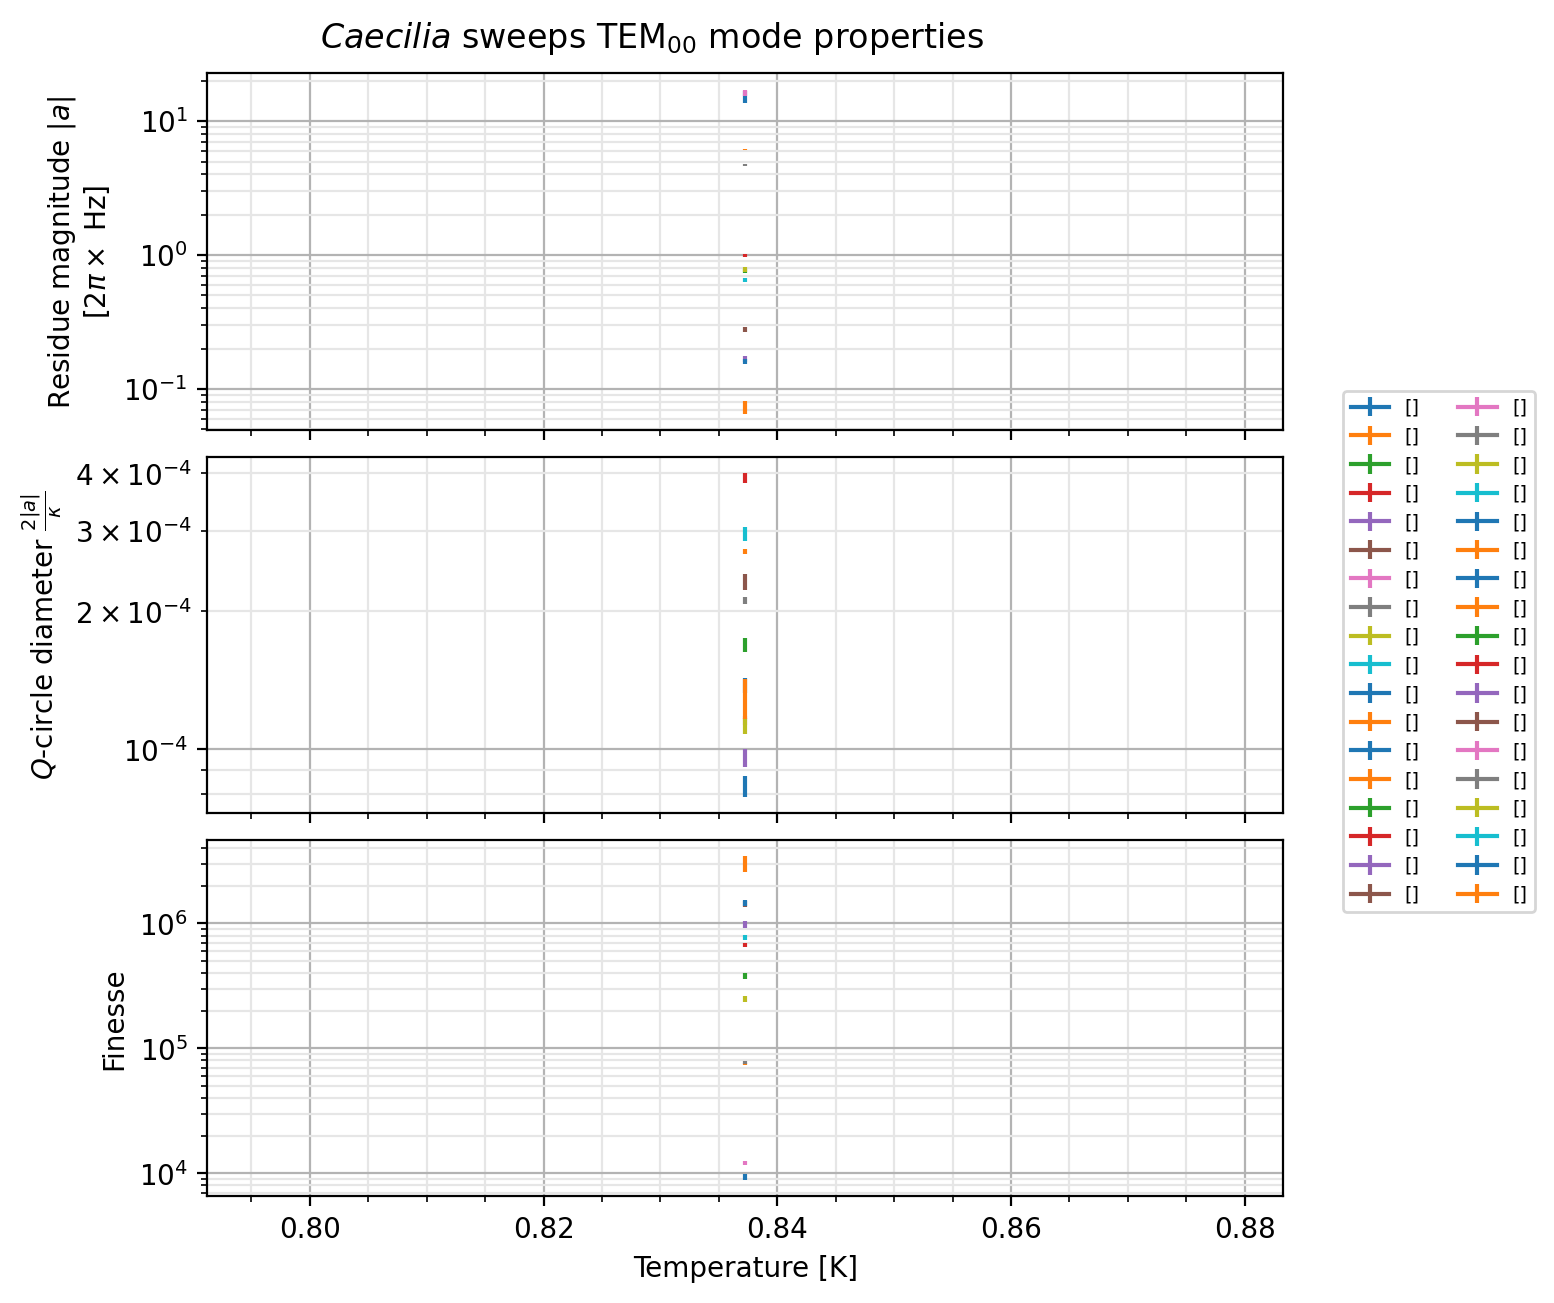

In [22]:
fig, axs = plt.subplots(figsize=(6.4, 6.4), nrows=3, sharex=True, layout='constrained')

for pol, single_pol_data in zip([+1, -1], all_modes_data):
    for mode_i, mode_info in enumerate(single_pol_data):
        marker = '.' if pol == +1 else 'x'
        polstr = 'x' if pol == +1 else 'y'
        
        q = mode_i + 26  # int(freq.n / mode_info.fsr)
        plot_kw = dict(
            marker=marker,
            linestyle='None',
            color=f'C{mode_i}',
        )        
        coupling_strength_plot(
            mode_info,
            masking_policy,
            axs,
            modelabel=f'TEM$_{{{q}, 0, 0, {polstr}}}$',
            **plot_kw,
        )

fig.legend(
    bbox_to_anchor=(1.04, 0.5),
    loc='center left',
    borderaxespad=0,
    ncol=2,
    fontsize='x-small',
)

for ax in axs:
    ax.set_yscale('log')
    sslab_style(ax)

fig.suptitle(r'$\it{Caecilia}$ sweeps TEM$_{00}$ mode properties')
coupling_strength_axs_setup(axs)
axs[-1].set_xlabel('Temperature [K]')

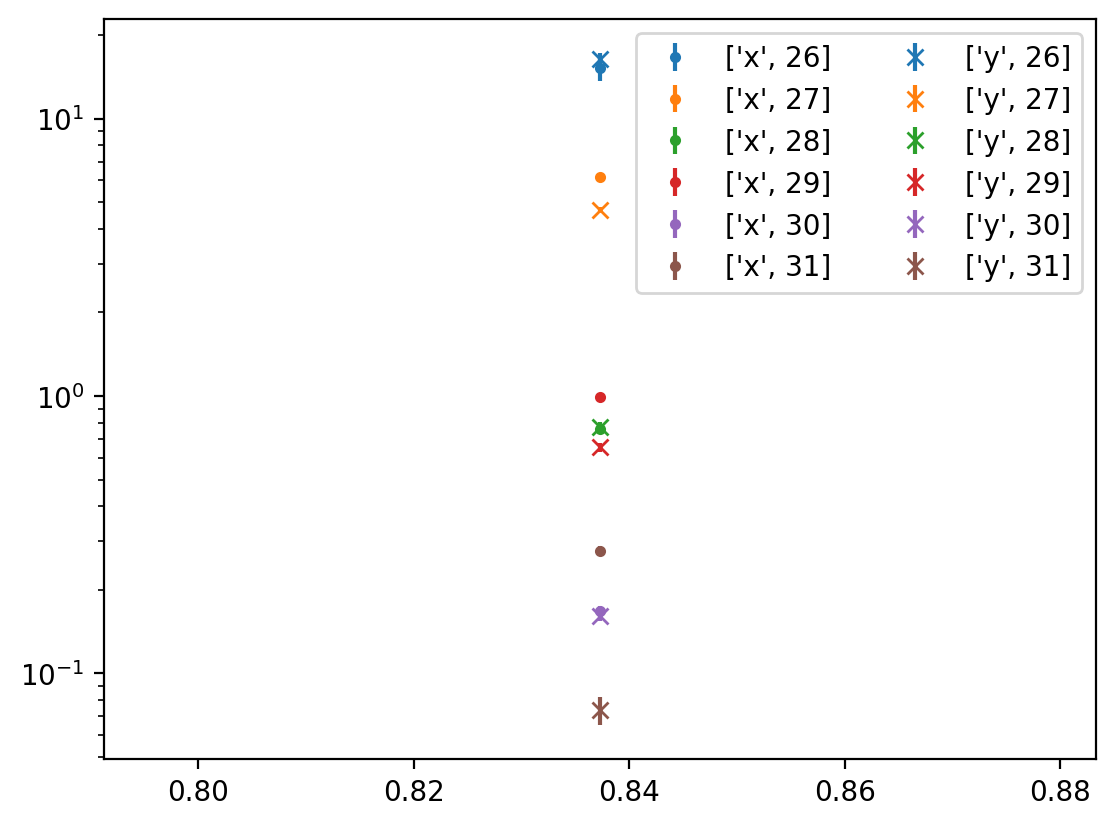

In [23]:
fig, ax = plt.subplots()

all_modes_data_ndim.errorbar_plot(
    all_modes_data_ndim.res_mag,
    ax=ax,
    kwarg_func=(
        lambda mode_data, *xcombo: dict(
            marker=('.' if xcombo[0] == 'x' else 'x'),
            linestyle='None',
            color=f'C{xcombo[1] - 26}',
        )
    ),
)
ax.set_yscale('log')
ax.legend(ncols=2)

Text(0.5, 0, 'Temperature [K]')

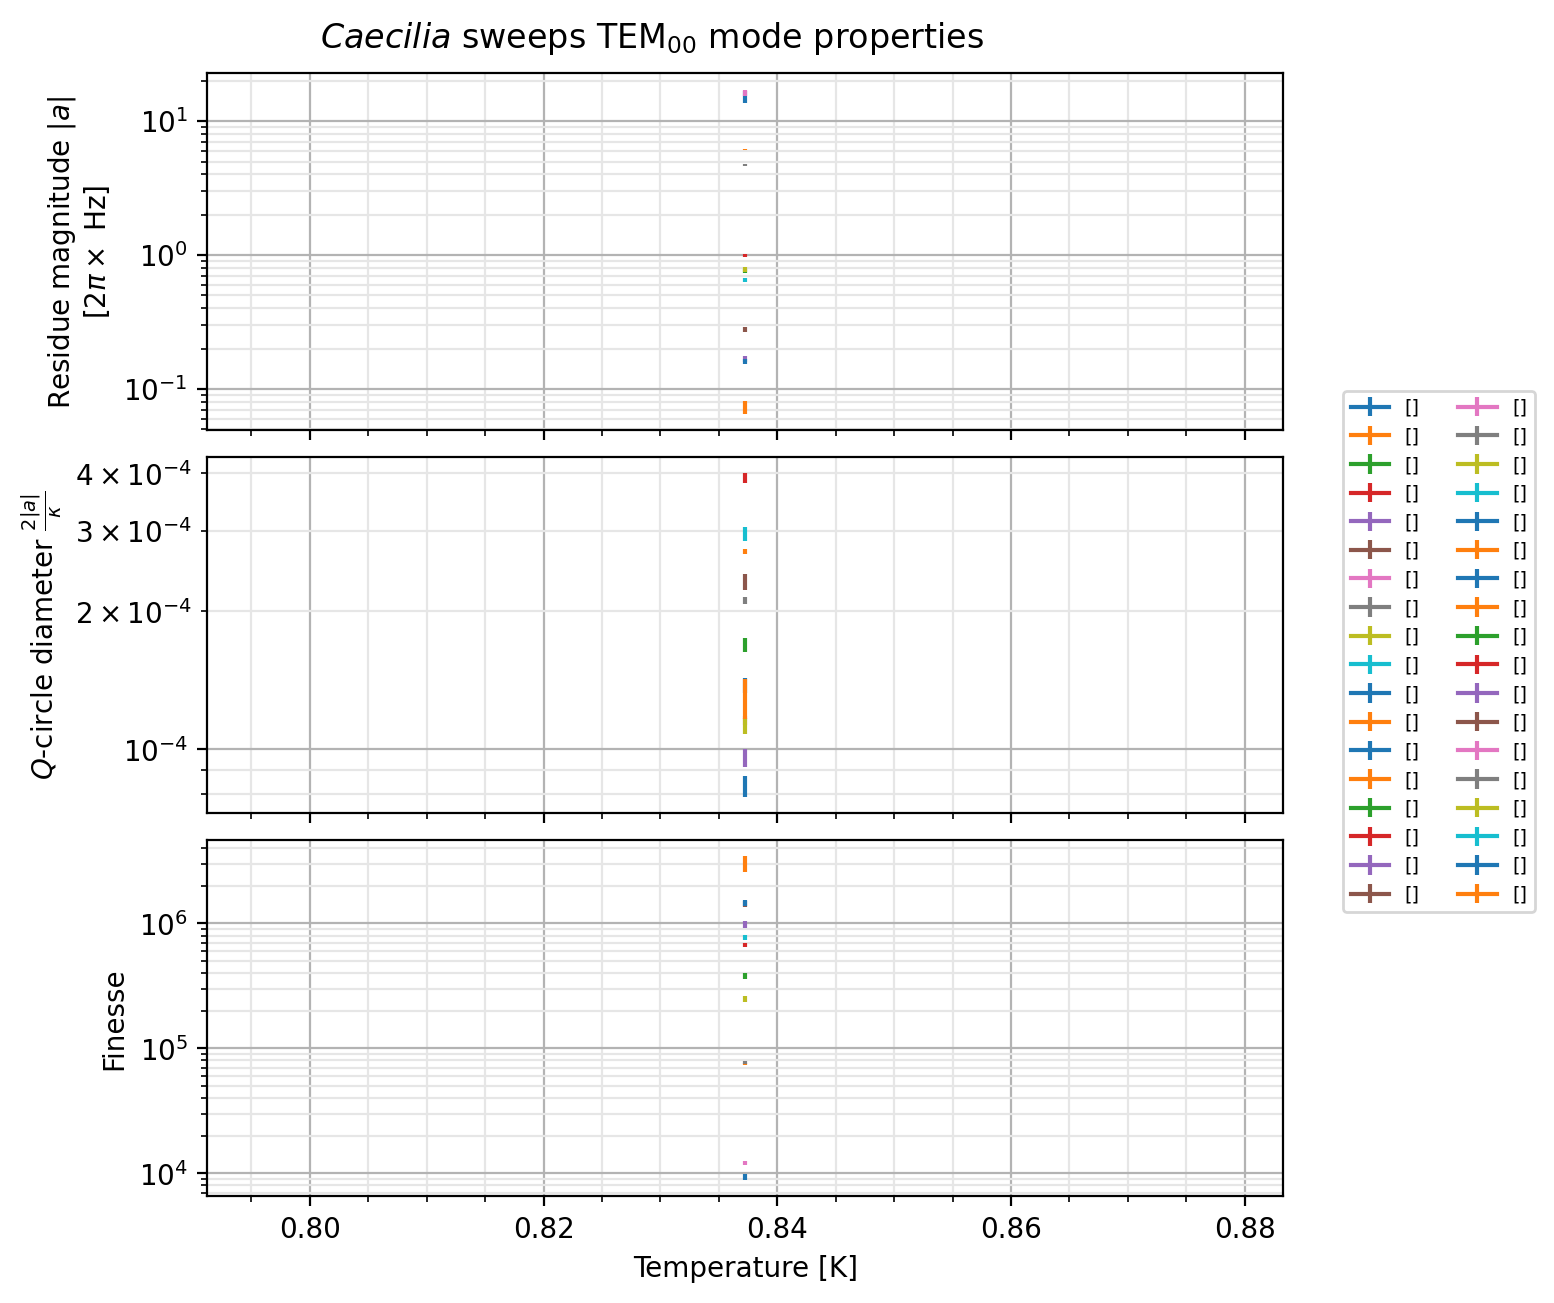

In [24]:
fig, axs = plt.subplots(figsize=(6.4, 6.4), nrows=3, sharex=True, layout='constrained')

for pol, single_pol_data in zip([+1, -1], all_modes_data):
    for mode_i, mode_info in enumerate(single_pol_data):
        marker = '.' if pol == +1 else 'x'
        polstr = 'x' if pol == +1 else 'y'
        
        q = mode_i + 26  # int(freq.n / mode_info.fsr)
        plot_kw = dict(
            marker=marker,
            linestyle='None',
            color=f'C{mode_i}',
        )        
        coupling_strength_plot(
            mode_info,
            masking_policy,
            axs,
            modelabel=f'TEM$_{{{q}, 0, 0, {polstr}}}$',
            **plot_kw,
        )

fig.legend(
    bbox_to_anchor=(1.04, 0.5),
    loc='center left',
    borderaxespad=0,
    ncol=2,
    fontsize='x-small',
)

for ax in axs:
    ax.set_yscale('log')
    sslab_style(ax)

fig.suptitle(r'$\it{Caecilia}$ sweeps TEM$_{00}$ mode properties')
coupling_strength_axs_setup(axs)
axs[-1].set_xlabel('Temperature [K]')

In [25]:
import pandas as pd

records = []
for pol_idx, pol_modes in enumerate(all_modes_info):
    pol = 'x' if pol_idx == 0 else 'y'
    for mode_idx, mode_sweeps in enumerate(pol_modes):
        q = mode_idx + 26
        for sweep_idx, sweep_info in enumerate(mode_sweeps):
            def get_n(x):
                if isinstance(x, float) and np.isnan(x):
                    return np.nan
                return x.n

            def get_s(x):
                if isinstance(x, float) and np.isnan(x):
                    return np.nan
                return x.s

            records.append({
                'pol': pol,
                'mode_q': q,
                'sweep_idx': sweep_idx,
                'pole_real_n': get_n(sweep_info['pole'][0]),
                'pole_real_s': get_s(sweep_info['pole'][0]),
                'pole_imag_n': get_n(sweep_info['pole'][1]),
                'pole_imag_s': get_s(sweep_info['pole'][1]),
                'residue_real_n': get_n(sweep_info['residue'][0]),
                'residue_real_s': get_s(sweep_info['residue'][0]),
                'residue_imag_n': get_n(sweep_info['residue'][1]),
                'residue_imag_s': get_s(sweep_info['residue'][1]),
            })

all_modes_df = pd.DataFrame(records)
all_modes_df.set_index(['sweep_idx', 'pol', 'mode_q'], inplace=True)
all_modes_df.sort_index(inplace=True)
all_modes_df.index = all_modes_df.index.droplevel()


In [26]:
all_modes_df

pole_real_n   pole_real_s   pole_imag_n   pole_imag_s  \
pol mode_q                                                           
x   26     -1.148471e+06  68997.494903  5.707464e+11  72418.020651   
    27     -1.430254e+05   2800.511663  5.922832e+11   2788.814714   
    28     -2.838387e+04   1375.589687  6.138179e+11   1375.868908   
    29     -1.595930e+04    561.719490  6.353519e+11    562.070055   
    30     -1.096329e+04    697.209955  6.568858e+11    697.208671   
    31     -7.498626e+03    440.361188  6.784195e+11    439.848449   
y   26     -8.908124e+05  33554.237549  5.707489e+11  33166.364632   
    27     -1.397167e+05   3468.125862  5.922860e+11   3486.656600   
    28     -4.334142e+04   2564.435034  6.138206e+11   2555.920973   
    29     -1.388722e+04    659.518998  6.353546e+11    659.101381   
    30     -7.343197e+03    396.923164  6.568884e+11    396.922403   
    31     -3.571335e+03    542.156340  6.784221e+11    541.989996   

            residue_real_n  residue_real_s  residue_imag_n  residue_imag_s  
pol mode_q                                                                  
x   26            6.385461        9.483292       95.205871        9.280009  
    27          -38.514709        0.570954       -2.674622        0.564928  
    28           -2.759889        0.165046        3.917289        0.165722  
    29           -1.313529        0.156784        6.111857        0.156444  
    30           -0.369782        0.047535       -0.984946        0.047535  
    31            0.083133        0.072373        1.738749        0.072542  
y   26           86.259399        5.644165       56.154716        5.101281  
    27          -23.884339        0.556996      -17.296541        0.550842  
    28           -3.597330        0.205659       -3.289852        0.205801  
    29            2.355767        0.137711       -3.357338        0.138097  
    30            0.810976        0.038634        0.605339        0.038634  
    31           -0.434108        0.052439        0.158518        0.052413

In [27]:
all_modes_df.to_csv('caecilia_condense_mode_info.csv', na_rep='NaN')